### Dataset Preparation

In [1]:
from pandas import read_csv
df = read_csv('KU-HAR_time_domain_subsamples_20750x300.csv',header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,1793,1794,1795,1796,1797,1798,1799,1800,1801,1802
0,0.004230,-0.000280,-0.013906,-0.002544,0.027433,0.058300,0.051670,0.071857,0.080653,0.047917,...,-0.016692,-0.018566,-0.017361,-0.017919,-0.016680,-0.016650,-0.013097,0,300,1
1,0.012482,0.032496,0.067856,0.071552,0.078103,0.040353,-0.001059,-0.018580,-0.026813,-0.011280,...,-0.008210,-0.010408,-0.011459,-0.011747,-0.010394,-0.008070,-0.004354,0,300,2
2,0.012127,0.028458,0.062075,0.052611,0.022942,-0.010017,-0.023151,-0.028515,0.005036,0.008450,...,0.000915,0.000771,-0.002560,-0.003020,-0.004190,0.000215,0.000850,0,300,3
3,0.052964,0.074319,0.110670,0.108490,0.091825,0.056989,0.029337,-0.016724,-0.042265,-0.053983,...,-0.001209,0.002878,0.000663,0.000982,-0.002148,-0.009200,-0.010653,0,300,4
4,-0.020462,-0.030787,-0.008617,0.008906,0.045046,0.042136,0.045037,0.045182,0.025113,0.021730,...,-0.006369,-0.006614,-0.004698,-0.007279,-0.006861,-0.006161,-0.006113,0,300,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20745,1.871600,1.648800,1.608900,1.802300,1.475000,1.390700,1.137800,1.289600,0.963750,1.022200,...,-0.497640,-0.432590,-0.414760,-0.363110,-0.329190,-0.460960,-0.621920,9,300,20746
20746,1.889400,2.022700,0.817300,-0.505840,2.462200,3.814200,2.661000,2.651200,1.991400,4.427300,...,-0.208820,-0.288930,-0.320880,-0.379540,-0.408210,-0.507970,-0.548040,9,300,20747
20747,1.269500,1.312200,0.725570,0.531290,0.958420,-0.049679,1.223100,1.837000,0.989740,1.882600,...,1.218500,1.125400,0.639470,0.277320,0.172710,-0.002894,0.023955,9,300,20748
20748,-5.562200,-2.797000,-2.353300,-3.075600,-4.136100,-4.028800,-0.580260,0.346070,-2.631700,-2.790000,...,-0.246670,-0.209020,-0.128670,-0.104730,-0.131960,-0.150780,-0.187320,9,300,20749


In [2]:
#from pandas import drop
df.drop([1801,1802], axis=1, inplace=True)

In [3]:
df.shape

(20750, 1801)

In [4]:
# the new dataset in which we are adding fft cols 

import numpy as np
import pandas as pd

features = df.values[:,0:1800]
labels = df.values[:,1800]

fft = np.zeros(features.shape, dtype=np.float32)

for i in range(0,len(features)):
    for j in range(0, 6):
        tmp = np.fft.fft(features[i, j*300:(j+1)*300])
        fft[i, j*300:(j+1)*300] = abs(tmp)
        
print(fft.shape)


# concatenating the fft and time domain signals - horizontal stacking

features = pd.DataFrame(features)
fft = pd.DataFrame(fft)
labels = pd.DataFrame(labels)

print(type(fft))
print(type(features))

df_new = pd.concat([features,fft], axis=1,ignore_index=True)

#adding labels to the new dataset

df_new = pd.concat([df_new,labels], axis=1,ignore_index=True)
df_new.shape

(20750, 1800)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


(20750, 3601)

In [5]:
df_new.to_csv('time_freq_domain_3sec.csv')

In [4]:
from sklearn.model_selection import train_test_split
from pandas import DataFrame
from pandas import concat
from numpy import dstack
from keras.utils import to_categorical


# #stacking such that features are the 3rd dimension
# function accepts a dataframe and number of cols(like 300,200 etc) for a single feature. returns a 3d numpy array
def to_3d_input(df1, cols): 
    l=list()
    for i in range(1,13):  # previously it was 7 after adding fft's 6 cols its now set to 13 i.e 12 cols
        l.append(df1.loc[:,(i-1)*cols:i*cols-1])    # 0-299 accX, 300-599 accY, 600-899 accZ; 900-1199 gyrx, 1200-1499 gyry, 1500-1799 gyrz
    X = dstack(l)
    return X


def split_dataset(df):  
    #accepts a dataframe as parameter
    # returns 4 dataframes
    #spliting the dataset first
    X = df.iloc[:,:-1]  # features
    Y = df.iloc[:,-1]   # labels

    print('Features shape : ',X.shape)
    print('Label shape : ',Y.shape, end='\n\n')

    labels = df[3600].unique() # can also replace it with arange(18)
    features_train, features_test,label_train, label_test = DataFrame(),DataFrame(),DataFrame(),DataFrame()

    for i in labels:
        data = df[df[3600] == i]
        rows = data.shape[0]
        train = round(rows*0.95) # spliting dataset into 75% training and 25% test

        #concatenating each class's train and test to 
        features_train = concat([features_train, data.iloc[:train]])
        label_train = concat([label_train,data.iloc[:train,3600]])
        features_test = concat([features_test,data.iloc[train:]])
        label_test = concat([label_test,data.iloc[train:,3600]]) 

    print("After data split : ")
    print('features_train : ',features_train.shape)
    print('features_test : ',features_test.shape)
    print('label_train : ',label_train.shape)
    print('label_test : ',label_test.shape,end = '\n\n')
    
    #generating 3d input
    features_train = to_3d_input(features_train, 300) # cols is 300 because its 3 sec dataset
    features_test =to_3d_input(features_test, 300)
    
    #one hot encoding of labels
    label_train = to_categorical(label_train)
    label_test = to_categorical(label_test)
    
    print("After applying dstack and one hot encoding : ")
    print('features_train : ',features_train.shape)
    print('features_test : ',features_test.shape)
    print('label_train : ',label_train.shape)
    print('label_test : ',label_test.shape,end = '\n\n')

    return features_train,features_test, label_train, label_test


In [5]:
#splitting the dataset
X_train, X_test, Y_train, Y_test = split_dataset(df_new)


Features shape :  (20750, 3600)
Label shape :  (20750,)

After data split : 
features_train :  (19712, 3601)
features_test :  (1038, 3601)
label_train :  (19712, 1)
label_test :  (1038, 1)

After applying dstack and one hot encoding : 
features_train :  (19712, 300, 12)
features_test :  (1038, 300, 12)
label_train :  (19712, 18)
label_test :  (1038, 18)



In [6]:
# Fit and evaluate a model

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def evaluate_model(trainX, trainy, testX, testy):
    epochs, batch_size = 15, 64
    verbose = 0
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    input_shape = (n_timesteps, n_features)
    
    model = Sequential()
    model.add(LSTM(128, input_shape=input_shape))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu')) 
    model.add(Dense(n_outputs, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
   
    
    y_predict = model.predict(testX)
    
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=verbose)
    print('Accuracy: {:.4f}'.format(accuracy))
    
    return y_predict

In [ ]:
y_predict = evaluate_model(X_train, Y_train, X_test, Y_test)

In [19]:
print(y_predict.shape)
print(Y_test.shape)

y_pred = np.argmax(y_predict, axis=1)
y_test= np.argmax(Y_test, axis=1)
print(y_pred.shape)
print(y_test.shape)

print('F1-score : ',f1_score(y_test, y_pred, average='weighted'))

(1038, 18)
(1038, 18)
(1038,)
(1038,)
F1-score :  0.9268391380371872


In [16]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test,y_pred)

              precision    recall  f1-score   support

           0       0.91      0.96      0.93        94
           1       0.96      0.82      0.89        94
           2       0.83      0.96      0.89        90
           3       0.98      0.96      0.97        93
           4       0.97      1.00      0.99       109
           5       0.94      0.89      0.92        91
           6       1.00      0.99      0.99        88
           7       0.80      0.99      0.89        67
           8       1.00      0.85      0.92        33
           9       0.83      0.42      0.56        24
          10       1.00      0.90      0.95        50
          11       0.95      0.91      0.93        44
          12       0.94      1.00      0.97        16
          13       0.73      0.85      0.79        13
          14       0.91      0.97      0.94        30
          15       0.89      1.00      0.94        40
          16       0.97      0.95      0.96        39
          17       0.96    

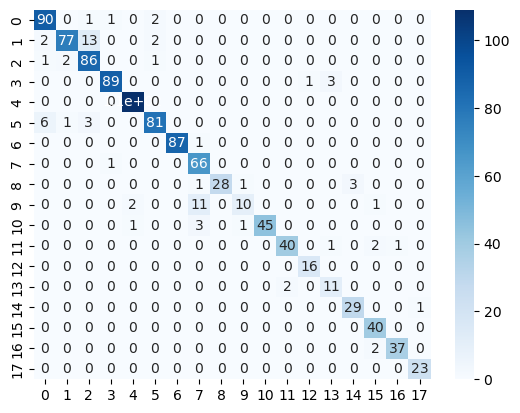

In [17]:
import seaborn as sn
ax = sn.heatmap(cm,annot=True,cmap='Blues')

In [60]:
ax.figure.savefig('lstm_cm.png')

###  CNN LSTM

In [24]:
# fit and evaluate a model - CNN LSTM
def evaluate_model(trainX, trainy, testX, testy):
    # define model
    verbose, epochs, batch_size = 0, 25, 64
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    # reshape data into time steps of sub-sequences
    n_steps, n_length = 4, 75
    trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
    testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
    # define model
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(Dropout(0.5)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(100))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    print('Accuracy of CNN-LSTM is ', accuracy)
    y_predict = model.predict(testX)
    return y_predict

In [25]:
#splitting the dataset
X_train, X_test, Y_train, Y_test = split_dataset(df_new)

Features shape :  (20750, 3600)
Label shape :  (20750,)

After data split : 
features_train :  (19712, 3601)
features_test :  (1038, 3601)
label_train :  (19712, 1)
label_test :  (1038, 1)

After applying dstack and one hot encoding : 
features_train :  (19712, 300, 12)
features_test :  (1038, 300, 12)
label_train :  (19712, 18)
label_test :  (1038, 18)



In [26]:
y_predict = evaluate_model(X_train, Y_train, X_test, Y_test) # CNN lstm

Accuracy of CNN-LSTM is  0.9383429884910583
33/33 [==============================] - 2s 15ms/step


In [27]:
# ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets
# we do the following because to evaluate accuracy you need a vector of labels

print(y_predict.shape)
print(Y_test.shape)

y_pred = np.argmax(y_predict, axis=1)
y_test= np.argmax(Y_test, axis=1)
print(y_pred.shape)
print(y_test.shape)

print('F1-score : ',f1_score(y_test, y_pred, average='weighted'))

(1038, 18)
(1038, 18)
(1038,)
(1038,)
F1-score :  0.9314555685966959


In [28]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test,y_pred)

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        94
           1       0.96      0.91      0.93        94
           2       0.89      0.92      0.91        90
           3       0.97      1.00      0.98        93
           4       1.00      1.00      1.00       109
           5       0.93      0.93      0.93        91
           6       0.99      1.00      0.99        88
           7       0.73      0.97      0.83        67
           8       0.97      0.88      0.92        33
           9       0.67      0.08      0.15        24
          10       0.98      0.92      0.95        50
          11       1.00      0.98      0.99        44
          12       1.00      1.00      1.00        16
          13       1.00      1.00      1.00        13
          14       0.91      0.97      0.94        30
          15       0.91      0.97      0.94        40
          16       1.00      0.95      0.97        39
          17       1.00    

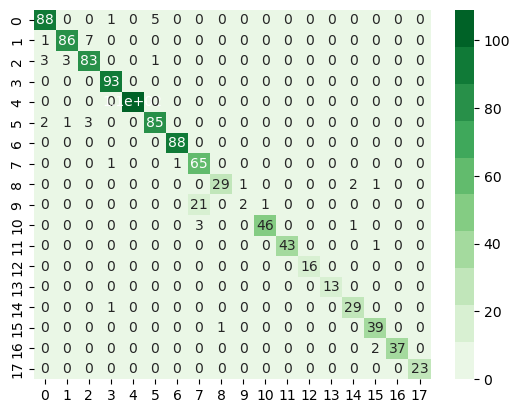

In [53]:
import seaborn as sns

colormap = sns.color_palette("Greens",10) 
ax = sn.heatmap(cm,annot=True,cmap=colormap)

### Conv-LSTM

In [ ]:
# fit and evaluate a model - Conv LSTM
def evaluate_conv_model(trainX, trainy, testX, testy):
    # define model
    verbose, epochs, batch_size = 0, 25, 64
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    # reshape into subsequences (samples, time steps, rows, cols, channels)
    n_steps, n_length = 4, 75 # 4*75 = 300, 300 if our timesteps
    trainX = trainX.reshape((trainX.shape[0], n_steps, 1, n_length, n_features))
    testX = testX.reshape((testX.shape[0], n_steps, 1, n_length, n_features))
    # define model
    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    print('Accuracy of Conv LSTM is ', accuracy)
    y_predict = model.predict(testX)
    return y_predict

In [56]:
y_predict = evaluate_conv_model(X_train, Y_train, X_test, Y_test)

Accuracy of Conv LSTM is  0.8978805541992188
33/33 [==============================] - 1s 15ms/step


In [57]:
print(y_predict.shape)
print(Y_test.shape)

y_pred = np.argmax(y_predict, axis=1)
y_test= np.argmax(Y_test, axis=1)
print(y_pred.shape)
print(y_test.shape)

print('F1-score : ',f1_score(y_test, y_pred, average='weighted'))

(1038, 18)
(1038, 18)
(1038,)
(1038,)
F1-score :  0.8897133765750855


In [58]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test,y_pred)

              precision    recall  f1-score   support

           0       0.84      0.85      0.85        94
           1       0.86      0.91      0.89        94
           2       0.94      0.81      0.87        90
           3       0.97      0.97      0.97        93
           4       0.95      0.95      0.95       109
           5       0.82      0.86      0.84        91
           6       0.95      0.99      0.97        88
           7       0.71      0.94      0.81        67
           8       0.97      0.91      0.94        33
           9       1.00      0.04      0.08        24
          10       0.98      0.88      0.93        50
          11       0.98      0.91      0.94        44
          12       1.00      1.00      1.00        16
          13       0.93      1.00      0.96        13
          14       0.97      0.97      0.97        30
          15       0.86      0.95      0.90        40
          16       0.90      0.97      0.94        39
          17       0.96    

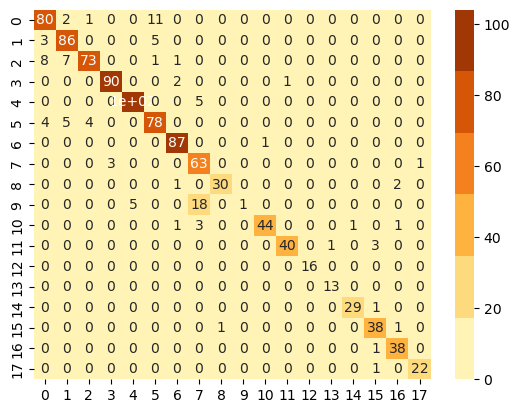

In [59]:
import seaborn as sns

colormap = sns.color_palette("YlOrBr")
ax = sn.heatmap(cm,annot=True,cmap=colormap)